# France Road Accidents Exploratory Data Analysis

This notebook provides comprehensive exploratory data analysis of accidents using the `fct_accidents_hr` model.


## Setup


### Import

In [49]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

### Class Import

In [50]:
# Data Loader
from data_loader import DataLoader

In [4]:
# Read data from BigQuery

hr_table = 'biking-in-paris.accidents.fct_accidents_hr'

bike_only_query = f"""
        SELECT *,
               -- Add geographic scope categorization
               CASE 
                 WHEN department = '75' THEN 'Paris'
                 WHEN department IN ('75', '77', '78', '91', '92', '93', '94', '95') THEN 'Île-de-France'
                 ELSE 'Other France'
               END as geographic_scope
        FROM `{hr_table}`
        WHERE vehicle_category_cd IN (1, 50, 80)
        """

print("Filtering for vehicle types: 1 (Bicycle), 50 (E-personal transport motorized), 80 (E-bicycle)")

data_loader = DataLoader(custom_query=bike_only_query, target_table=hr_table)

df = data_loader.load_from_bigquery()

Filtering for vehicle types: 1 (Bicycle), 50 (E-personal transport motorized), 80 (E-bicycle)
Loading data using custom query...


/Users/zoe/Downloads/safe-biking-in-paris/ml_env/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Loaded 28,578 records from BigQuery


In [51]:
from severity_eda import SeverityEDA, PlotConfig

In [52]:
eda = SeverityEDA()

eda.set_data(df)

print(f"Vehicle types included: {df['vehicle_category_label'].unique()}")

Vehicle types included: ['Bicycle' 'E‑personal transport (motorized)' 'E‑bicycle']


## Analysis

In [53]:
eda.summary()


=== Severity overview ===
Fatality             |     893 cases |   3.1%
Hospitalized injury  |   5,926 cases |  20.7%
Minor injury         |  19,000 cases |  66.5%
Unharmed             |   2,741 cases |   9.6%
Unknown              |      18 cases |   0.1%
Total accidents: 28578


### Geographic: Paris, Île-de-France, Other France


=== Severity by geographic_scope ===

Other France (n=17,405)
  Fatality             |   4.7% (814)
  Hospitalized injury  |  29.8% (5,191)
  Minor injury         |  60.2% (10,484)
  Unharmed             |   5.2% (906)
  Unknown              |   0.1% (10)

Île-de-France (n=4,324)
  Fatality             |   1.4% (60)
  Hospitalized injury  |  10.6% (459)
  Minor injury         |  79.3% (3,428)
  Unharmed             |   8.6% (371)
  Unknown              |   0.1% (6)

Paris (n=6,849)
  Fatality             |   0.3% (19)
  Hospitalized injury  |   4.0% (276)
  Minor injury         |  74.3% (5,088)
  Unharmed             |  21.4% (1,464)
  Unknown              |   0.0% (2)


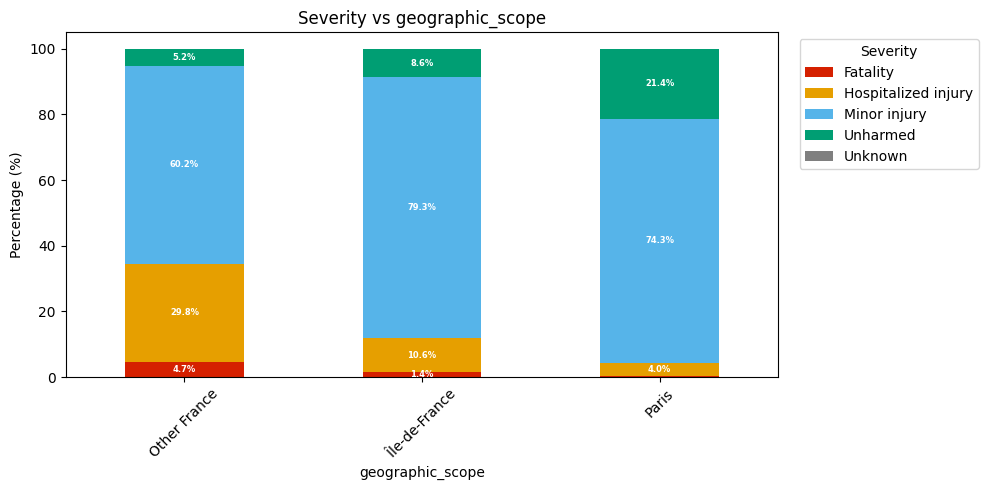

(severity_label    Fatality  Hospitalized injury  Minor injury   Unharmed  \
 geographic_scope                                                           
 Other France      4.676817            29.824763     60.235564   5.205401   
 Île-de-France     1.387604            10.615171     79.278446   8.580019   
 Paris             0.277413             4.029785     74.288217  21.375383   
 
 severity_label     Unknown  
 geographic_scope            
 Other France      0.057455  
 Île-de-France     0.138760  
 Paris             0.029201  ,
 severity_label    Fatality  Hospitalized injury  Minor injury  Unharmed  \
 geographic_scope                                                          
 Other France           814                 5191         10484       906   
 Paris                   19                  276          5088      1464   
 Île-de-France           60                  459          3428       371   
 
 severity_label    Unknown  
 geographic_scope           
 Other France         

In [54]:
eda.analyze("geographic_scope")

In [41]:
# define function to create heatmap
def create_heatmap(df, location, zoom_start, radius, blur):
    heat_map_df = df.copy()
    heat_map_df.dropna(subset=['latitude', 'longitude'], inplace=True)
    heat_map = folium.Map(location=location, zoom_start=zoom_start)
    heat_data = heat_map_df[['latitude', 'longitude']].values.tolist()
    HeatMap(
        heat_data,
        radius=radius,          
        blur=blur,           
        max_zoom=1,        
        gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}  
    ).add_to(heat_map)
    return heat_map

In [42]:
france_heat_map = create_heatmap(df, [46.2276, 2.2137], zoom_start=6, radius=6, blur=8)

france_heat_map

## IDF only

In [27]:
idf_df = df[(df['geographic_scope'] == 'Île-de-France') | (df['geographic_scope'] == 'Paris')]

In [28]:
idf_eda =  SeverityEDA()

idf_eda.set_data(idf_df)

In [29]:
idf_eda.summary()


=== Severity overview ===
Fatality             |      79 cases |   0.7%
Hospitalized injury  |     735 cases |   6.6%
Minor injury         |   8,516 cases |  76.2%
Unharmed             |   1,835 cases |  16.4%
Unknown              |       8 cases |   0.1%
Total accidents: 11173


In [45]:
idf_heat_map = create_heatmap(idf_df, [48.8566, 2.3522], zoom_start=12, radius=6, blur=8)

idf_heat_map

In [38]:
idf_severe_df = df[(df['severity_cd'] == 3) | (df['severity_cd'] == 2)]

idf_severe_df.head()

,user_id,accident_id,vehicle_id,user_role_cd,user_role_label,severity_cd,severity_label,gender_cd,gender_label,birth_year,...,number_of_lanes,public_transport_lane_cd,latitude,longitude,geom,accident_year,speed_limit_kmh,vehicles_in_accident,users_in_accident,geographic_scope
3,203 763 476,202300037000,155 614 981,1,Driver,3,Hospitalized injury,1,Male,1964,...,3,0,47.678838,-2.739855,POINT(-2.739855 47.678838),2023,50,2,2,Other France
12,203 790 096,202300025752,155 634 957,1,Driver,3,Hospitalized injury,1,Male,1984,...,2,0,49.358089,0.075989,POINT(0.075989 49.358089),2023,50,2,2,Other France
17,203 810 321,202300017185,155 650 119,1,Driver,2,Fatality,1,Male,1927,...,2,0,48.921952,2.294807,POINT(2.29480737 48.92195238),2023,50,2,2,Île-de-France
28,203 746 814,202300043930,155 602 652,1,Driver,3,Hospitalized injury,1,Male,1961,...,2,0,48.468248,-4.717292,POINT(-4.717292 48.468248),2023,80,2,2,Other France
29,203 751 465,202300042032,155 606 078,1,Driver,3,Hospitalized injury,1,Male,2006,...,2,0,49.037190,-1.231002,POINT(-1.231002 49.03719),2023,80,2,2,Other France


In [48]:
idf_severe_heat_map = create_heatmap(idf_severe_df, [48.8566, 2.3522], 
                                     zoom_start=12, radius=10, blur=12)

idf_severe_heat_map

### Temporal & Environmental


=== Severity by time_of_day_label ===

Night (n=232)
  Fatality             |   4.3% (10)
  Hospitalized injury  |  16.8% (39)
  Minor injury         |  75.0% (174)
  Unharmed             |   3.4% (8)
  Unknown              |   0.4% (1)

Off‑peak (n=1,764)
  Fatality             |   1.3% (23)
  Hospitalized injury  |  11.5% (203)
  Minor injury         |  78.8% (1,390)
  Unharmed             |   8.3% (147)
  Unknown              |   0.1% (1)

Evening peak (n=1,380)
  Fatality             |   1.0% (14)
  Hospitalized injury  |  10.4% (143)
  Minor injury         |  78.3% (1,081)
  Unharmed             |  10.1% (140)
  Unknown              |   0.1% (2)

Morning peak (n=948)
  Fatality             |   1.4% (13)
  Hospitalized injury  |   7.8% (74)
  Minor injury         |  82.6% (783)
  Unharmed             |   8.0% (76)
  Unknown              |   0.2% (2)


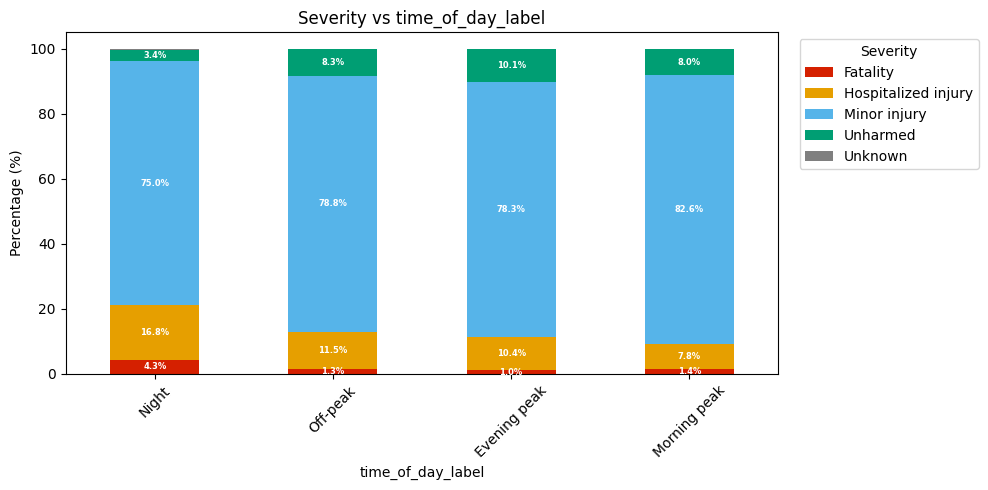


=== Severity by light_condition_label ===

Night – no lighting (n=64)
  Fatality             |   7.8% (5)
  Hospitalized injury  |  23.4% (15)
  Minor injury         |  59.4% (38)
  Unharmed             |   9.4% (6)
  Unknown              |   0.0% (0)

Night – lighting on (n=683)
  Fatality             |   2.9% (20)
  Hospitalized injury  |  11.6% (79)
  Minor injury         |  78.5% (536)
  Unharmed             |   6.9% (47)
  Unknown              |   0.1% (1)

Twilight / dawn (n=274)
  Fatality             |   1.5% (4)
  Hospitalized injury  |  10.9% (30)
  Minor injury         |  78.8% (216)
  Unharmed             |   8.8% (24)
  Unknown              |   0.0% (0)

Full daylight (n=3,288)
  Fatality             |   0.9% (31)
  Hospitalized injury  |  10.2% (334)
  Minor injury         |  79.8% (2,625)
  Unharmed             |   8.9% (293)
  Unknown              |   0.2% (5)

Night – lighting off (n=15)
  Fatality             |   0.0% (0)
  Hospitalized injury  |   6.7% (1)
  Minor i

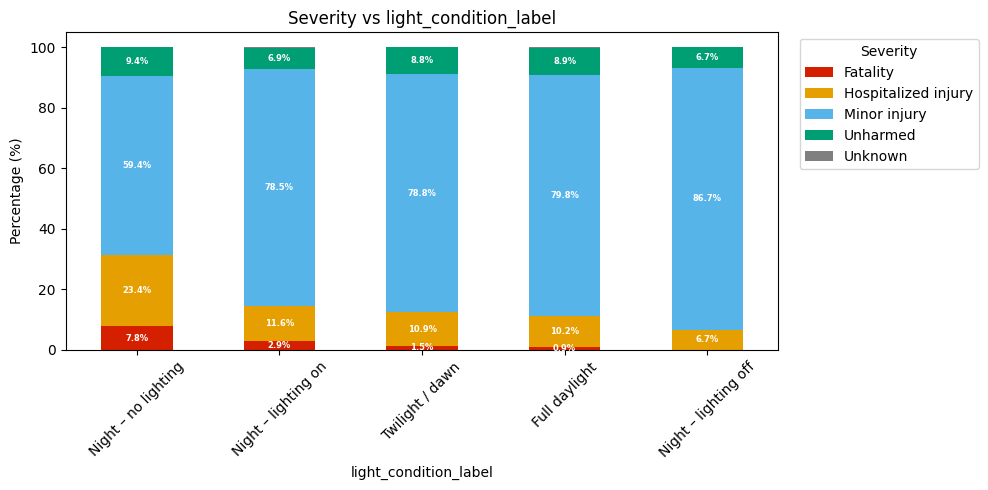


=== Severity by weather_condition_label ===

Fog or smoke (n=3)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  33.3% (1)
  Minor injury         |  66.7% (2)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Snow or hail (n=3)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  33.3% (1)
  Minor injury         |  66.7% (2)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Strong wind / storm (n=7)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  28.6% (2)
  Minor injury         |  42.9% (3)
  Unharmed             |  28.6% (2)
  Unknown              |   0.0% (0)

Heavy rain (n=69)
  Fatality             |   2.9% (2)
  Hospitalized injury  |  23.2% (16)
  Minor injury         |  69.6% (48)
  Unharmed             |   4.3% (3)
  Unknown              |   0.0% (0)

Glare (n=60)
  Fatality             |   3.3% (2)
  Hospitalized injury  |  15.0% (9)
  Minor injury         |  76.7% (46)
  Unharmed             |

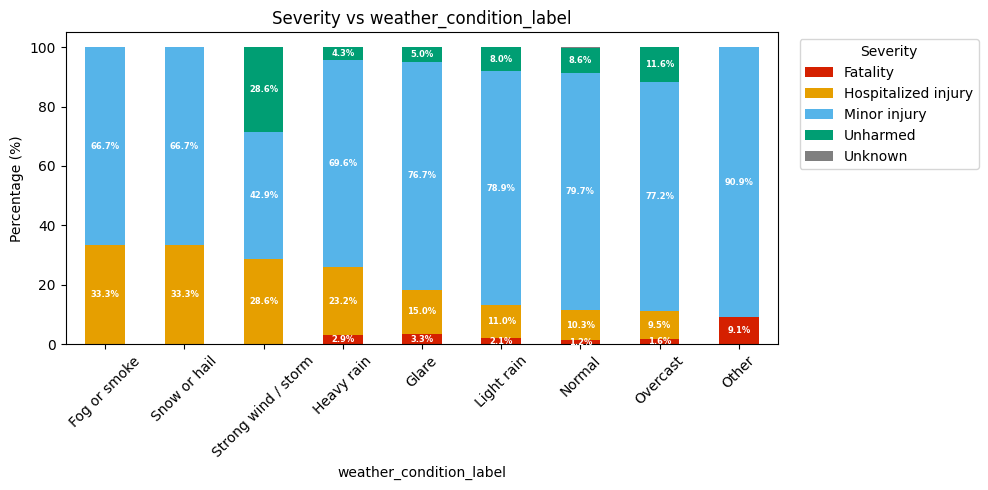


=== Severity by surface_condition_label ===

Snow‑covered (n=1)
  Fatality             |   0.0% (0)
  Hospitalized injury  | 100.0% (1)
  Minor injury         |   0.0% (0)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Mud (n=2)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  50.0% (1)
  Minor injury         |  50.0% (1)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Puddles (n=6)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  50.0% (3)
  Minor injury         |  50.0% (3)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Other (n=15)
  Fatality             |  20.0% (3)
  Hospitalized injury  |  26.7% (4)
  Minor injury         |  26.7% (4)
  Unharmed             |  26.7% (4)
  Unknown              |   0.0% (0)

Greasy / Oily (n=3)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  33.3% (1)
  Minor injury         |  66.7% (2)
  Unharmed             |   0.0% (0)
  Unknown 

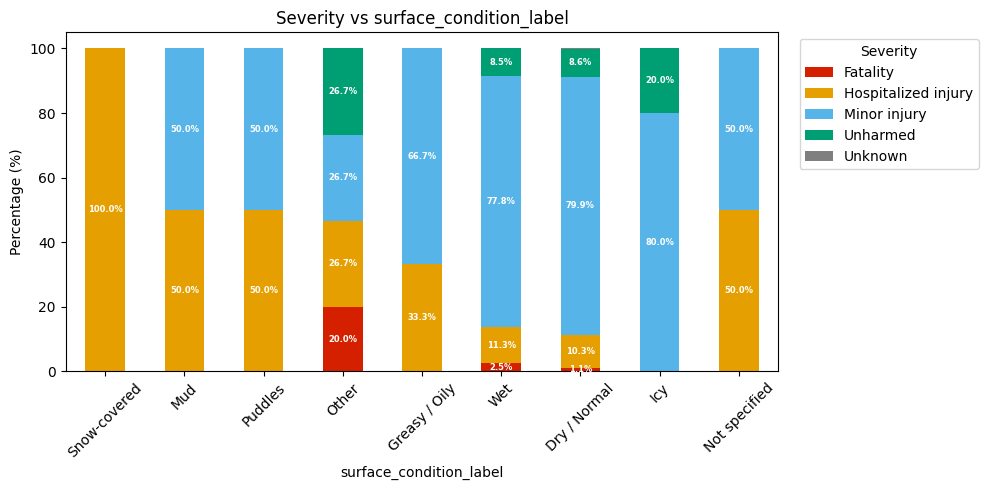

In [16]:
temporal_cols = [
    "time_of_day_label",      
    "light_condition_label",   
    "weather_condition_label", 
    "surface_condition_label"  
]

for col in temporal_cols:
    if col in df.columns:
        idf_eda.analyze(col)
        

### Infrastructure


=== Severity by infrastructure_label ===

Roadworks (n=26)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  19.2% (5)
  Minor injury         |  80.8% (21)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Slip road / ramp (n=11)
  Fatality             |   9.1% (1)
  Hospitalized injury  |   9.1% (1)
  Minor injury         |  81.8% (9)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Level crossing (n=16)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  12.5% (2)
  Minor injury         |  81.2% (13)
  Unharmed             |   6.2% (1)
  Unknown              |   0.0% (0)

Modified intersection (n=306)
  Fatality             |   1.3% (4)
  Hospitalized injury  |  10.8% (33)
  Minor injury         |  80.7% (247)
  Unharmed             |   7.2% (22)
  Unknown              |   0.0% (0)

Other (n=198)
  Fatality             |   2.0% (4)
  Hospitalized injury  |   9.1% (18)
  Minor injury         |  79.3% (157)
  Unharme

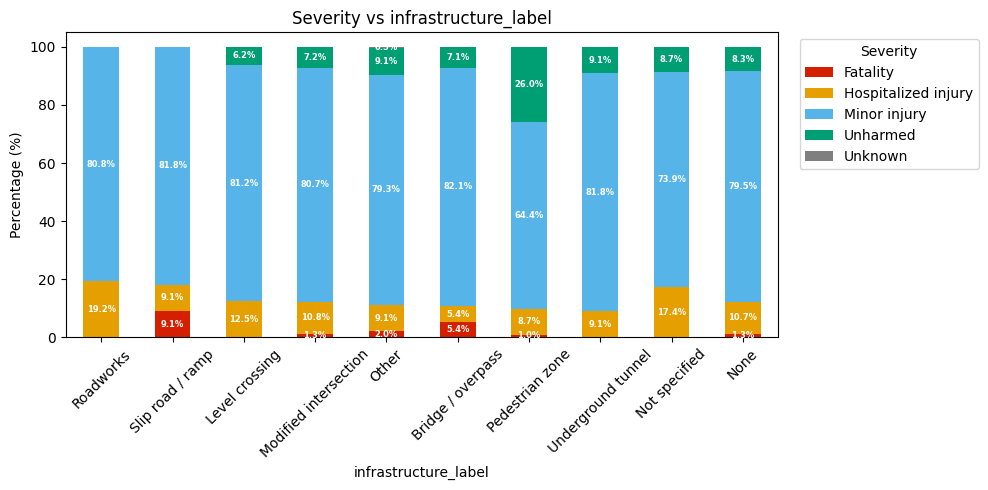


=== Severity by intersection_type_label ===

Y‑intersection (n=69)
  Fatality             |   2.9% (2)
  Hospitalized injury  |  18.8% (13)
  Minor injury         |  73.9% (51)
  Unharmed             |   4.3% (3)
  Unknown              |   0.0% (0)

Roundabout (n=300)
  Fatality             |   0.3% (1)
  Hospitalized injury  |  14.7% (44)
  Minor injury         |  80.3% (241)
  Unharmed             |   4.7% (14)
  Unknown              |   0.0% (0)

Not at intersection (n=2,000)
  Fatality             |   1.6% (32)
  Hospitalized injury  |  11.5% (229)
  Minor injury         |  75.8% (1,515)
  Unharmed             |  11.1% (222)
  Unknown              |   0.1% (2)

T‑intersection (n=728)
  Fatality             |   1.9% (14)
  Hospitalized injury  |   9.6% (70)
  Minor injury         |  81.2% (591)
  Unharmed             |   7.3% (53)
  Unknown              |   0.0% (0)

Other (n=271)
  Fatality             |   0.4% (1)
  Hospitalized injury  |   9.2% (25)
  Minor injury         |  81.

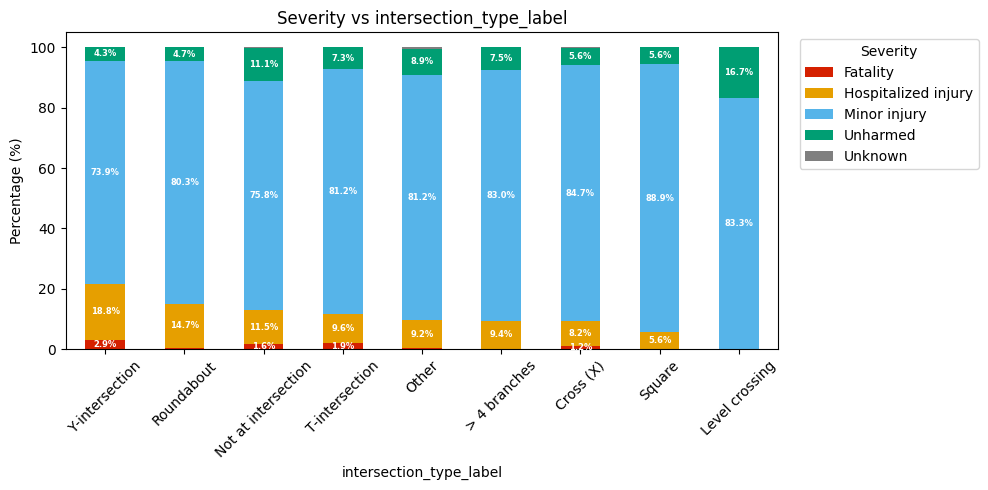


=== Severity by road_category_label ===

Outside public network (n=6)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  33.3% (2)
  Minor injury         |  66.7% (4)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Public parking area (n=8)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  25.0% (2)
  Minor injury         |  62.5% (5)
  Unharmed             |  12.5% (1)
  Unknown              |   0.0% (0)

Other (n=31)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  22.6% (7)
  Minor injury         |  61.3% (19)
  Unharmed             |  16.1% (5)
  Unknown              |   0.0% (0)

National road (n=32)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  12.5% (4)
  Minor injury         |  84.4% (27)
  Unharmed             |   3.1% (1)
  Unknown              |   0.0% (0)

Departmental road (n=2,515)
  Fatality             |   1.7% (42)
  Hospitalized injury  |  10.2% (257)
  Minor injury         |  80.4% (2,021)


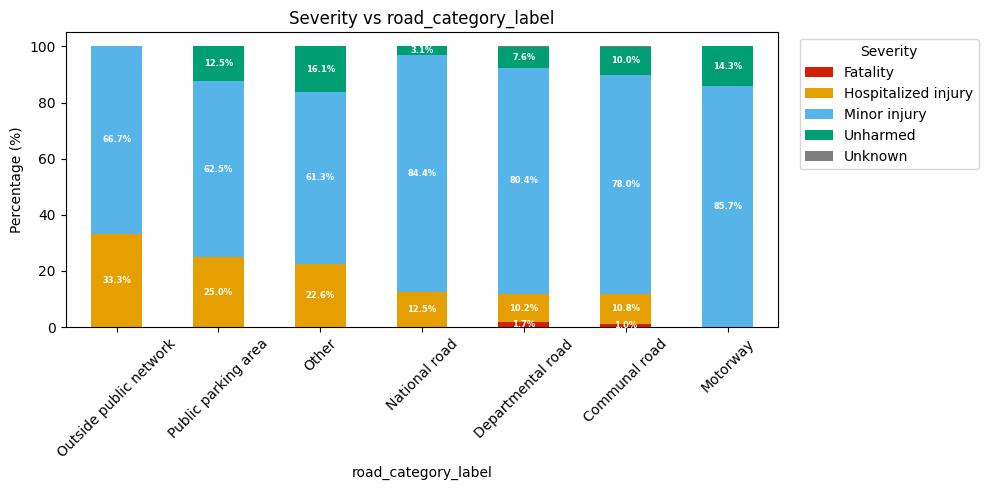


=== Severity by urban_area_label ===

Outside urban area (n=163)
  Fatality             |   6.7% (11)
  Hospitalized injury  |  31.3% (51)
  Minor injury         |  58.9% (96)
  Unharmed             |   3.1% (5)
  Unknown              |   0.0% (0)

Within urban area (n=4,161)
  Fatality             |   1.2% (49)
  Hospitalized injury  |   9.8% (408)
  Minor injury         |  80.1% (3,332)
  Unharmed             |   8.8% (366)
  Unknown              |   0.1% (6)


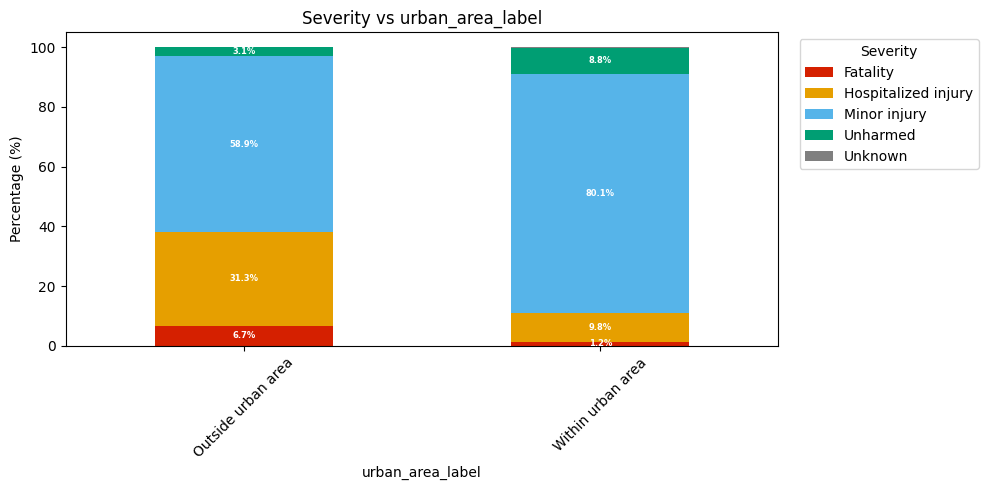

In [17]:
infrastructure_cols = [
    "infrastructure_label",    
    "intersection_type_label", 
    "road_category_label",     
    "urban_area_label"        
]

for col in infrastructure_cols:
    if col in df.columns:
        idf_eda.analyze(col)

### Personal 


=== Severity by age_group_label ===

Senior (n=224)
  Fatality             |   6.7% (15)
  Hospitalized injury  |  21.0% (47)
  Minor injury         |  70.1% (157)
  Unharmed             |   2.2% (5)
  Unknown              |   0.0% (0)

Older adult (n=660)
  Fatality             |   2.3% (15)
  Hospitalized injury  |  13.2% (87)
  Minor injury         |  79.1% (522)
  Unharmed             |   5.5% (36)
  Unknown              |   0.0% (0)

Child (n=202)
  Fatality             |   2.0% (4)
  Hospitalized injury  |   9.9% (20)
  Minor injury         |  79.2% (160)
  Unharmed             |   8.9% (18)
  Unknown              |   0.0% (0)

Youth (n=471)
  Fatality             |   0.8% (4)
  Hospitalized injury  |  10.6% (50)
  Minor injury         |  77.7% (366)
  Unharmed             |  10.8% (51)
  Unknown              |   0.0% (0)

Mid adult (n=1,142)
  Fatality             |   1.3% (15)
  Hospitalized injury  |   9.6% (110)
  Minor injury         |  82.1% (938)
  Unharmed             | 

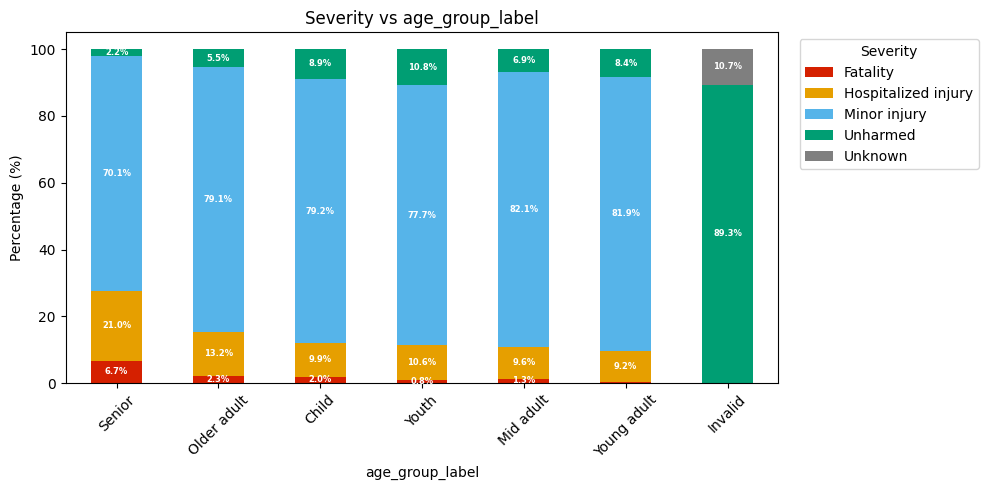


=== Severity by helmet_label ===

Wearing helmet (n=1,352)
  Fatality             |   1.2% (16)
  Hospitalized injury  |  11.8% (159)
  Minor injury         |  79.5% (1,075)
  Unharmed             |   7.5% (102)
  Unknown              |   0.0% (0)

No helmet (n=2,972)
  Fatality             |   1.5% (44)
  Hospitalized injury  |  10.1% (300)
  Minor injury         |  79.2% (2,353)
  Unharmed             |   9.1% (269)
  Unknown              |   0.2% (6)


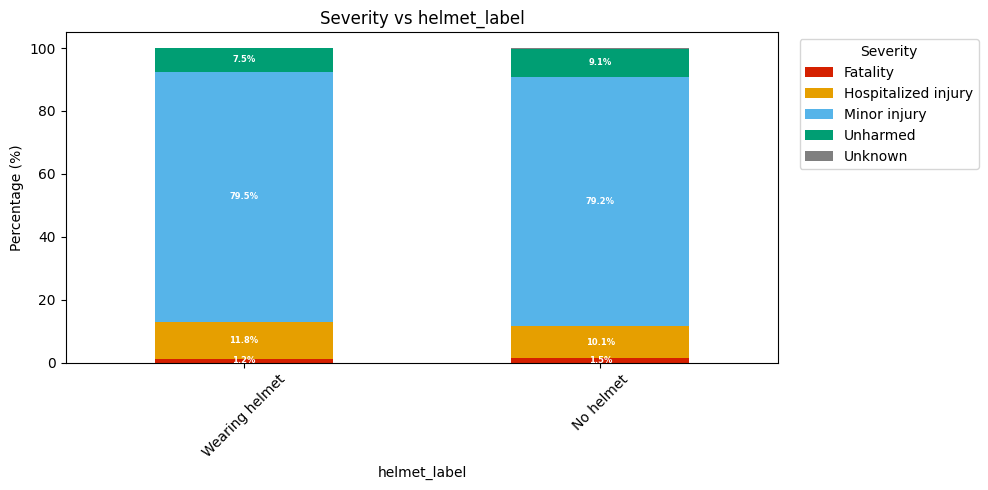


=== Severity by gender_label ===

Male (n=3,225)
  Fatality             |   1.4% (45)
  Hospitalized injury  |  11.0% (356)
  Minor injury         |  79.1% (2,552)
  Unharmed             |   8.4% (272)
  Unknown              |   0.0% (0)

Female (n=1,049)
  Fatality             |   1.4% (15)
  Hospitalized injury  |   9.8% (103)
  Minor injury         |  83.5% (876)
  Unharmed             |   5.2% (55)
  Unknown              |   0.0% (0)

Unknown (n=50)
  Fatality             |   0.0% (0)
  Hospitalized injury  |   0.0% (0)
  Minor injury         |   0.0% (0)
  Unharmed             |  88.0% (44)
  Unknown              |  12.0% (6)


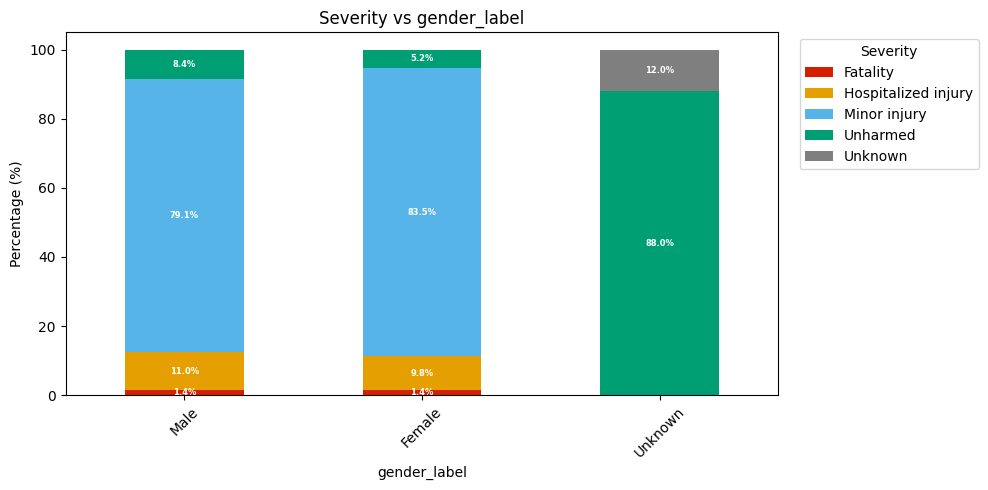


=== Severity by trip_purpose_label ===

Shopping (n=55)
  Fatality             |   7.3% (4)
  Hospitalized injury  |  21.8% (12)
  Minor injury         |  65.5% (36)
  Unharmed             |   5.5% (3)
  Unknown              |   0.0% (0)

Leisure (n=1,096)
  Fatality             |   2.5% (27)
  Hospitalized injury  |  16.4% (180)
  Minor injury         |  73.6% (807)
  Unharmed             |   7.5% (82)
  Unknown              |   0.0% (0)

Home–school (n=205)
  Fatality             |   1.0% (2)
  Hospitalized injury  |  10.2% (21)
  Minor injury         |  75.1% (154)
  Unharmed             |  13.7% (28)
  Unknown              |   0.0% (0)

Other (n=298)
  Fatality             |   0.7% (2)
  Hospitalized injury  |   9.1% (27)
  Minor injury         |  82.6% (246)
  Unharmed             |   7.7% (23)
  Unknown              |   0.0% (0)

Home–work (n=903)
  Fatality             |   0.9% (8)
  Hospitalized injury  |   8.5% (77)
  Minor injury         |  83.6% (755)
  Unharmed            

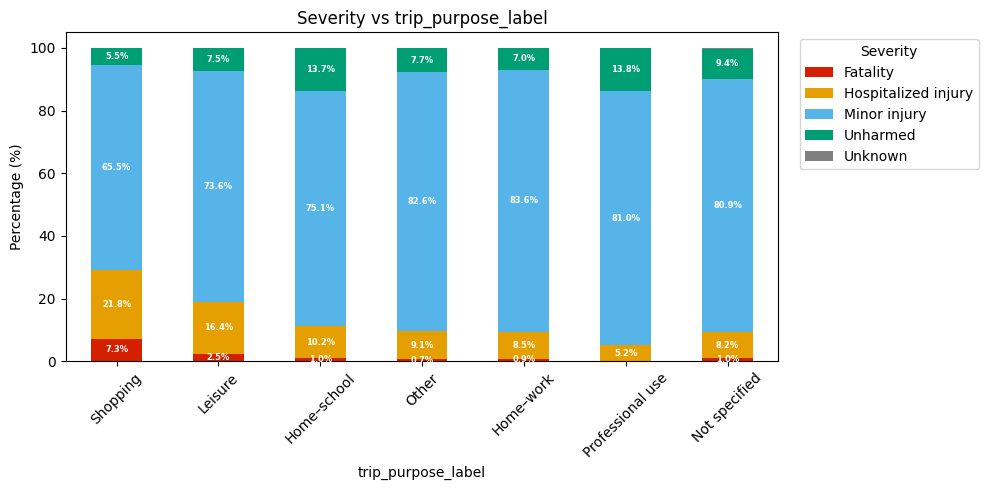


=== Severity by vehicle_category_label ===

Bicycle (n=2,533)
  Fatality             |   1.5% (38)
  Hospitalized injury  |  10.7% (271)
  Minor injury         |  79.9% (2,024)
  Unharmed             |   7.8% (197)
  Unknown              |   0.1% (3)

E‑personal transport (motorized) (n=1,578)
  Fatality             |   1.3% (21)
  Hospitalized injury  |  10.6% (167)
  Minor injury         |  78.1% (1,232)
  Unharmed             |   9.9% (156)
  Unknown              |   0.1% (2)

E‑bicycle (n=213)
  Fatality             |   0.5% (1)
  Hospitalized injury  |   9.9% (21)
  Minor injury         |  80.8% (172)
  Unharmed             |   8.5% (18)
  Unknown              |   0.5% (1)


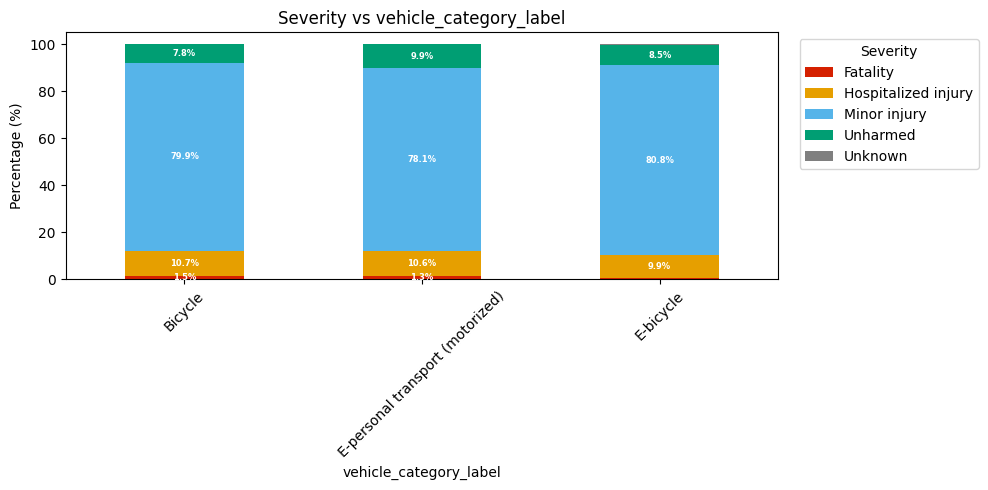

In [18]:
safety_cols = [
    "age_group_label",
    "helmet_label",             
    "gender_label",           
    "trip_purpose_label",     
    "vehicle_category_label" 
]

for col in safety_cols:
    if col in df.columns:
        idf_eda.analyze(col)